In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [221]:
df = pd.read_csv('Data/raw/tech_salaries.csv')

print("Primeras 5 filas del DataFrame:")
print(df.head())

Primeras 5 filas del DataFrame:
   Unnamed: 0  work_year experience_level employment_type           job_title  \
0           0       2025               MI              FT  Penetration Tester   
1           1       2025               MI              CT   Security Engineer   
2           2       2025               MI              CT   Security Engineer   
3           3       2025               MI              FT   Security Engineer   
4           4       2025               MI              FT   Security Engineer   

    salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0  1336608             INR          15804                 IN             0   
1   130000             USD         130000                 US             0   
2   120000             USD         120000                 US             0   
3   120000             USD         120000                 US             0   
4    80000             USD          80000                 US             0   

  company_lo

In [222]:
print("Valores únicos en 'experience_level':")
print(df['experience_level'].unique())

print("\nValores únicos en 'employment_type':")
print(df['employment_type'].unique())

print("\nValores únicos en 'company_size':")
print(df['company_size'].unique())

Valores únicos en 'experience_level':
['MI' 'SE' 'EN' 'EX']

Valores únicos en 'employment_type':
['FT' 'CT' 'PT' 'FL']

Valores únicos en 'company_size':
['L' 'M' 'S']


## Abbreviations Meaning Guide
These are the standard abbreviations:

### Experience Level (`experience_level`)
* **EN**: Entry-level / Junior
* **MI**: Mid-level / Intermediate  
* **SE**: Senior-level / Expert
* **EX**: Executive-level / Director

### Employment Type (`employment_type`)
* **FT**: Full-time
* **PT**: Part-time
* **CT**: Contract
* **FL**: Freelance

In [223]:
print("\nInformación general del DataFrame:")
df.info()



Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65117 entries, 0 to 65116
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          65117 non-null  int64 
 1   work_year           65117 non-null  int64 
 2   experience_level    65117 non-null  object
 3   employment_type     65117 non-null  object
 4   job_title           65117 non-null  object
 5   salary              65117 non-null  int64 
 6   salary_currency     65117 non-null  object
 7   salary_in_usd       65117 non-null  int64 
 8   employee_residence  65117 non-null  object
 9   remote_ratio        65117 non-null  int64 
 10  company_location    65117 non-null  object
 11  company_size        65117 non-null  object
dtypes: int64(5), object(7)
memory usage: 6.0+ MB


In [224]:
missing_values = df.isnull().sum()

print(missing_values)

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


In [225]:
print("\nEstadísticas descriptivas de las columnas numéricas:")
print(df.describe())


Estadísticas descriptivas de las columnas numéricas:
         Unnamed: 0     work_year        salary  salary_in_usd  remote_ratio
count  65117.000000  65117.000000  6.511700e+04   65117.000000  65117.000000
mean   32010.679331   2024.395903  1.677303e+05  145093.128354     20.254311
std    18789.833314      0.819922  3.071000e+06   62600.555119     39.949287
min        0.000000   2020.000000  4.000000e+03    2859.000000      0.000000
25%    15727.000000   2024.000000  1.000000e+05  100000.000000      0.000000
50%    32006.000000   2025.000000  1.369000e+05  136218.000000      0.000000
75%    48285.000000   2025.000000  1.802000e+05  180000.000000      0.000000
max    64564.000000   2025.000000  6.000000e+08  750000.000000    100.000000


* Data: You have 65,117 records in total.

* Relevance: The data is very current, mainly from 2024-2025.

* Key Salary: The salary_in_usd column is the one you should use for analysis. The median salary is $136k USD.

* Work Modality: The vast majority of offers are for 100% on-site work.

In [226]:
num_duplicates = df.duplicated().sum()

print(f"Número de filas duplicadas: {num_duplicates}")

Número de filas duplicadas: 0


### Experience Level Analysis

--- Distribución por Nivel de Experiencia ---
Conteo:
experience_level
SE    36310
MI    20376
EN     6701
EX     1730
Name: count, dtype: int64

Porcentaje (%):
experience_level
SE    55.761168
MI    31.291368
EN    10.290707
EX     2.656756
Name: proportion, dtype: float64


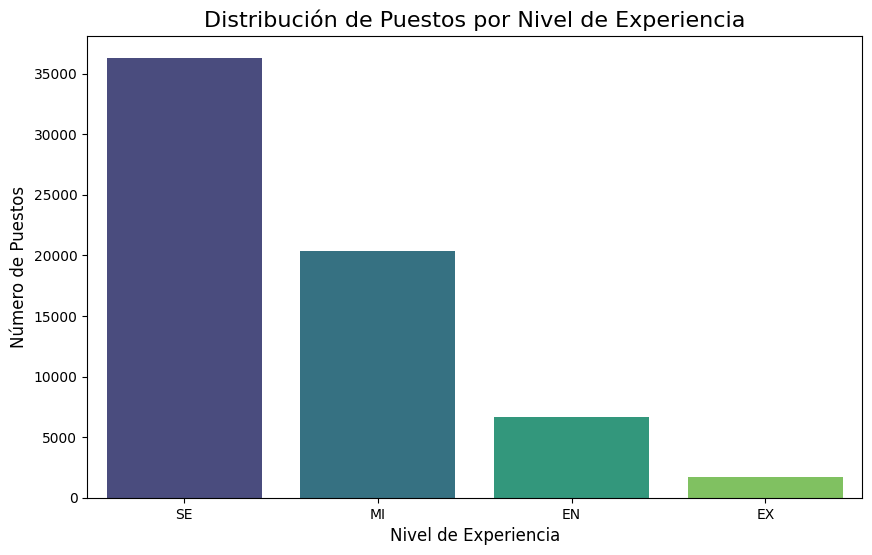

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Distribución por Nivel de Experiencia ---")

# Contar los valores y los porcentajes
experience_counts = df['experience_level'].value_counts()
experience_percentages = df['experience_level'].value_counts(normalize=True) * 100

print("Conteo:")
print(experience_counts)
print("\nPorcentaje (%):")
print(experience_percentages)

plt.figure(figsize=(10, 6))
sns.barplot(x=experience_counts.index, y=experience_counts.values, palette='viridis')
plt.title('Distribución de Puestos por Nivel de Experiencia', fontsize=16)
plt.xlabel('Nivel de Experiencia', fontsize=12)
plt.ylabel('Número de Puestos', fontsize=12)
plt.show()

Senior and mid-level positions together account for 87% of the dataset. This means that any calculation of an “average” salary we make will be heavily influenced by the salaries of profiles with considerable experience.

### Jobs

In [228]:
job_title_counts = df['job_title'].value_counts().head(15)

print("Los 15 puestos de trabajo más comunes:")
print(job_title_counts)

Los 15 puestos de trabajo más comunes:
job_title
Security Engineer               15478
Security Analyst                 5029
Manager                          3248
Software Engineer                2590
Analyst                          1914
Security Architect               1795
Systems Engineer                 1710
Consultant                       1599
DevSecOps Engineer               1375
Security Specialist              1132
Systems Administrator            1117
Program Manager                  1004
Information Security Officer      905
Cyber Security                    865
Network Engineer                  755
Name: count, dtype: int64


### Location

In [229]:
location_counts = df['company_location'].value_counts().head(10)

print("Los 10 países con más puestos de trabajo:")
print(location_counts)

Los 10 países con más puestos de trabajo:
company_location
US    58976
CA     2128
GB     1358
DE      481
NL      303
AU      297
AT      170
SK      146
FR      113
ES       89
Name: count, dtype: int64


It tells us that the dataset is not a global representation of tech salaries, but is overwhelmingly dominated by the United States.

* United States (US): 58,976 jobs, which is approximately 90.6% of the entire dataset.

* All other countries: The remaining 9 countries in the top 10 make up only a small fraction of the total.

### Size of the company

In [230]:
size_counts = df['company_size'].value_counts()

print("Conteo de trabajos por tamaño de empresa:")
print(size_counts)

Conteo de trabajos por tamaño de empresa:
company_size
M    62528
L     2365
S      224
Name: count, dtype: int64


The salary trends we observe will mainly reflect the compensation practices of medium-sized companies in the United States.

### Type of employement

In [231]:
employment_counts = df['employment_type'].value_counts()
print(employment_counts)

employment_type
FT    64817
PT      196
CT       93
FL       11
Name: count, dtype: int64


This output clearly shows the dataset is almost entirely composed of full-time (FT) positions, accounting for over 99.5% of all roles. Contract (CT), part-time (PT), and freelance (FL) roles are extremely rare.

In [232]:
residence_counts = df['employee_residence'].value_counts().head(10)
print(residence_counts)

employee_residence
US    58909
CA     2132
GB     1353
DE      479
NL      303
AU      298
AT      169
SK      147
FR      121
ES       96
Name: count, dtype: int64


This confirms that the employees' residences align almost perfectly with the company locations. Over 90% of the employees in the dataset live in the United States. This reinforces that our analysis is firmly centered on the US job market, with very little influence from international or remote work across borders.

### Remote Work Distribution

In [233]:
remote_counts = df['remote_ratio'].value_counts()
print(remote_counts)

remote_ratio
0      51677
100    12938
50       502
Name: count, dtype: int64


* Presencial (0): 51,677 jobs (79.4%)

* Remoto (100): 12,938 jobs (19.9%)

* Hybrid (50): 502 jobs (<1%)

## Data cleansing and preparation

In [234]:
df_clean = df.copy()
df_clean = df_clean.rename(columns={'Unnamed: 0': 'worker_id'})

# Distribución de registros por año
year_distribution = df['work_year'].value_counts().sort_index()
print("Distribución de registros por año:")
print(year_distribution)

# Porcentaje por año
year_percentage = df['work_year'].value_counts(normalize=True).sort_index() * 100
print("\nPorcentaje de registros por año:")
for year, pct in year_percentage.items():
    print(f"{year}: {pct:.1f}%")

Distribución de registros por año:
work_year
2020      246
2021      684
2022     1347
2023     3496
2024    24338
2025    35006
Name: count, dtype: int64

Porcentaje de registros por año:
2020: 0.4%
2021: 1.1%
2022: 2.1%
2023: 5.4%
2024: 37.4%
2025: 53.8%


## VISUALIZACIÓN DE LA EVOLUCIÓN TEMPORAL

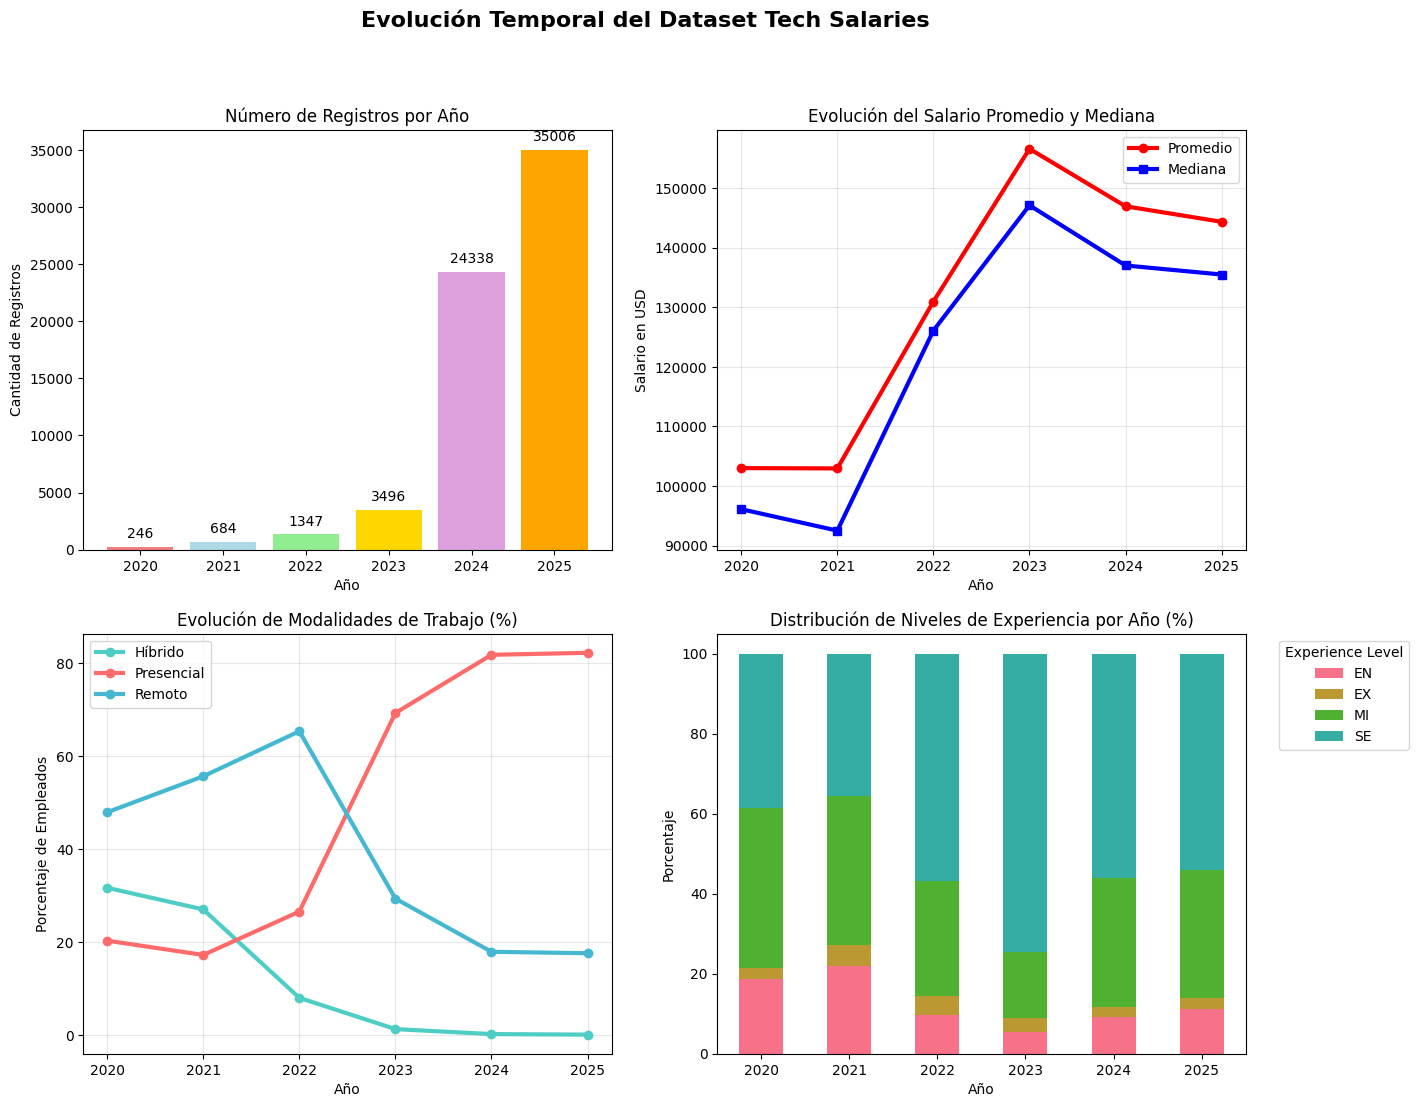

In [235]:
# Crear subplots para análisis temporal
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Evolución Temporal del Dataset Tech Salaries', fontsize=16, fontweight='bold')

# 1. Cantidad de registros por año
axes[0,0].bar(year_distribution.index, year_distribution.values, 
              color=['lightcoral', 'lightblue', 'lightgreen', 'gold', 'plum', 'orange'][:len(year_distribution)])
axes[0,0].set_title('Número de Registros por Año')
axes[0,0].set_xlabel('Año')
axes[0,0].set_ylabel('Cantidad de Registros')
for i, v in enumerate(year_distribution.values):
    axes[0,0].text(year_distribution.index[i], v + 500, str(v), ha='center', va='bottom')

# 2. Evolución del salario promedio por año
salary_by_year = df.groupby('work_year')['salary_in_usd'].agg(['mean', 'median']).round(0)
axes[0,1].plot(salary_by_year.index, salary_by_year['mean'], marker='o', linewidth=3, label='Promedio', color='red')
axes[0,1].plot(salary_by_year.index, salary_by_year['median'], marker='s', linewidth=3, label='Mediana', color='blue')
axes[0,1].set_title('Evolución del Salario Promedio y Mediana')
axes[0,1].set_xlabel('Año')
axes[0,1].set_ylabel('Salario en USD')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Evolución del trabajo remoto por año
df['work_mode'] = df['remote_ratio'].apply(lambda x: 'Presencial' if x == 0 
                                                    else 'Híbrido' if x == 50 
                                                    else 'Remoto' if x == 100 
                                                    else 'Otro')

# Calcular distribución por año y modalidad
work_mode_by_year = pd.crosstab(df['work_year'], df['work_mode'], normalize='index') * 100

# Graficar evolución de modalidades
work_mode_colors = {'Presencial': '#FF6B6B', 'Híbrido': '#4ECDC4', 'Remoto': '#45B7D1', 'Otro': '#96CEB4'}
for mode in work_mode_by_year.columns:
    if mode in work_mode_colors:
        axes[1,0].plot(work_mode_by_year.index, work_mode_by_year[mode], 
                      marker='o', linewidth=3, label=mode, color=work_mode_colors[mode])

axes[1,0].set_title('Evolución de Modalidades de Trabajo (%)')
axes[1,0].set_xlabel('Año')
axes[1,0].set_ylabel('Porcentaje de Empleados')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Distribución de niveles de experiencia por año
exp_by_year = pd.crosstab(df['work_year'], df['experience_level'], normalize='index') * 100
exp_by_year.plot(kind='bar', stacked=True, ax=axes[1,1])
axes[1,1].set_title('Distribución de Niveles de Experiencia por Año (%)')
axes[1,1].set_xlabel('Año')
axes[1,1].set_ylabel('Porcentaje')
axes[1,1].legend(title='Experience Level', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].tick_params(axis='x', rotation=0)

### ANÁLISIS DETALLADO DE MODALIDADES DE TRABAJO


ANÁLISIS DE MODALIDADES DE TRABAJO
Distribución general de modalidades de trabajo:
Presencial: 51,677 empleados (79.4%)
Remoto: 12,938 empleados (19.9%)
Híbrido: 502 empleados (0.8%)

Distribución de modalidades por año (%):
work_mode  Híbrido  Presencial  Remoto
work_year                             
2020          31.7        20.3    48.0
2021          27.0        17.3    55.7
2022           8.0        26.6    65.4
2023           1.3        69.3    29.4
2024           0.2        81.9    17.9
2025           0.1        82.3    17.6


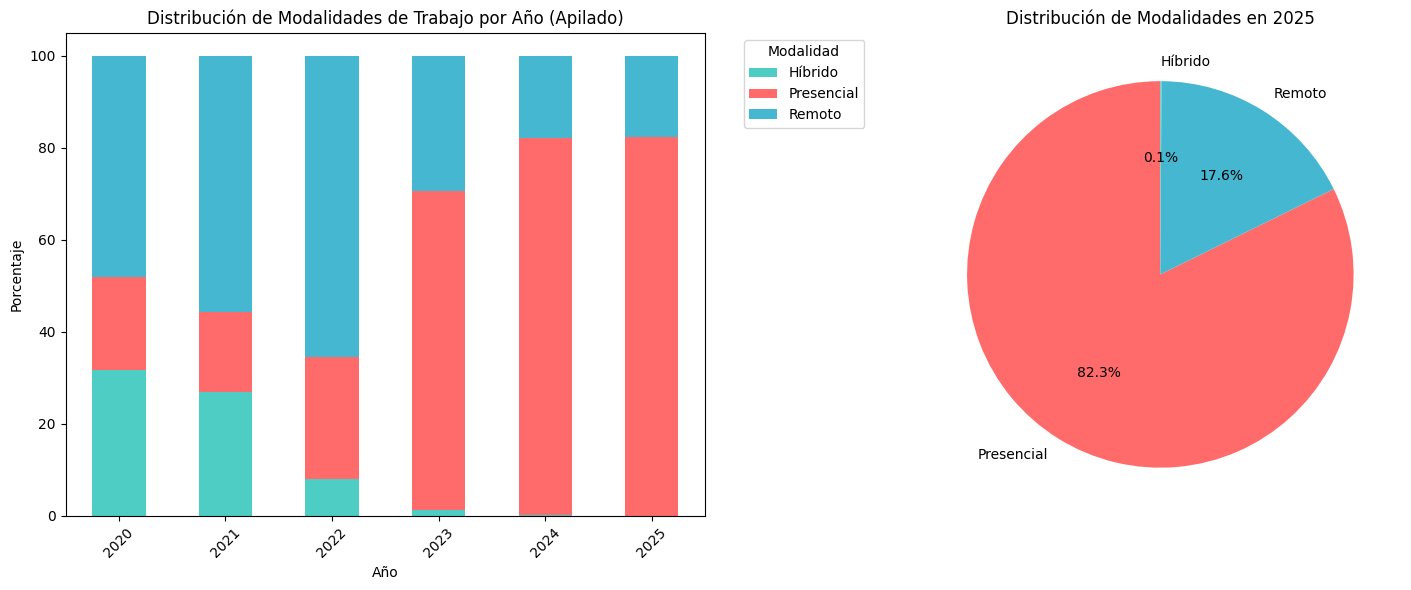

In [236]:
print("\n" + "="*60)
print("ANÁLISIS DE MODALIDADES DE TRABAJO")
print("="*60)

# Distribución general de modalidades
work_mode_distribution = df['work_mode'].value_counts()
print("Distribución general de modalidades de trabajo:")
for mode, count in work_mode_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"{mode}: {count:,} empleados ({percentage:.1f}%)")

# Distribución por año
print("\nDistribución de modalidades por año (%):")
print(work_mode_by_year.round(1))

# Crear visualización adicional de modalidades
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras apiladas
work_mode_by_year.plot(kind='bar', stacked=True, ax=ax1, 
                      color=[work_mode_colors.get(col, 'gray') for col in work_mode_by_year.columns])
ax1.set_title('Distribución de Modalidades de Trabajo por Año (Apilado)')
ax1.set_xlabel('Año')
ax1.set_ylabel('Porcentaje')
ax1.legend(title='Modalidad', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# Gráfico circular para el año más reciente
latest_year = df['work_year'].max()
latest_distribution = df[df['work_year'] == latest_year]['work_mode'].value_counts()
colors_pie = [work_mode_colors.get(mode, 'gray') for mode in latest_distribution.index]
ax2.pie(latest_distribution.values, labels=latest_distribution.index, autopct='%1.1f%%', 
        colors=colors_pie, startangle=90)
ax2.set_title(f'Distribución de Modalidades en {latest_year}')

plt.tight_layout()
plt.show()

## ESTADÍSTICAS DETALLADAS POR AÑO INCLUYENDO MODALIDADES

In [237]:
print("\n" + "="*60)
print("ESTADÍSTICAS DETALLADAS POR AÑO")
print("="*60)

# Crear tabla resumen por año incluyendo modalidades
summary_by_year = df.groupby('work_year').agg({
    'salary_in_usd': ['count', 'mean', 'median', 'std'],
    'experience_level': lambda x: x.value_counts().index[0]  # Nivel más común
}).round(2)

# Aplanar nombres de columnas
summary_by_year.columns = ['Count', 'Salary_Mean', 'Salary_Median', 'Salary_Std', 'Most_Common_Level']

# Agregar información de modalidades
for year in summary_by_year.index:
    year_data = df[df['work_year'] == year]
    most_common_mode = year_data['work_mode'].value_counts().index[0]
    summary_by_year.loc[year, 'Most_Common_Work_Mode'] = most_common_mode

print("Resumen por año:")
print(summary_by_year)


ESTADÍSTICAS DETALLADAS POR AÑO
Resumen por año:
           Count  Salary_Mean  Salary_Median  Salary_Std Most_Common_Level  \
work_year                                                                    
2020         246    102997.91        96099.0    58634.06                MI   
2021         684    102939.77        92500.0    58660.73                MI   
2022        1347    130948.37       126080.0    58814.85                SE   
2023        3496    156580.83       147100.0    62602.98                SE   
2024       24338    146934.89       137000.0    63800.85                SE   
2025       35006    144329.13       135482.0    61426.74                SE   

          Most_Common_Work_Mode  
work_year                        
2020                     Remoto  
2021                     Remoto  
2022                     Remoto  
2023                 Presencial  
2024                 Presencial  
2025                 Presencial  


### IDENTIFICACIÓN DE PUNTOS DE INFLEXIÓN (BOOM DE LA IA)

In [238]:
print("\n" + "="*60)
print("ANÁLISIS DE PUNTOS DE INFLEXIÓN")
print("="*60)

# Calculamos cambios año a año
salary_changes = summary_by_year['Salary_Mean'].pct_change() * 100

print("Cambio porcentual en salario promedio año a año:")
for year in salary_changes.index[1:]:  # Empezar desde el segundo año
    change = salary_changes[year]
    print(f"{year-1} -> {year}: {change:+.1f}%")

# Análisis de cambios en modalidades de trabajo
print("\nCambios en modalidades de trabajo:")
for year in work_mode_by_year.index[1:]:
    prev_year = year - 1
    if prev_year in work_mode_by_year.index:
        print(f"\nCambios {prev_year} -> {year}:")
        for mode in work_mode_by_year.columns:
            change = work_mode_by_year.loc[year, mode] - work_mode_by_year.loc[prev_year, mode]
            print(f"  {mode}: {change:+.1f} puntos porcentuales")

# Identificar años con mayor crecimiento
max_salary_growth_year = salary_changes.idxmax()

print(f"\n" + "="*60)
print(f"AÑO CON MAYOR CRECIMIENTO SALARIAL: {max_salary_growth_year}")
if not pd.isna(salary_changes[max_salary_growth_year]):
    print(f"Crecimiento: {salary_changes[max_salary_growth_year]:+.1f}%")
print("="*60)

print("\n" + "="*60)
print("CONTEXTO DEL BOOM DE LA IA:")
print("- 2022-2023: Lanzamiento de ChatGPT (Nov 2022)")
print("- 2023-2024: Boom de herramientas de IA generativa") 
print("- 2024-2025: Adopción masiva de IA en empresas")
print("¿Observamos cambios significativos en estos períodos?")
print("="*60)


ANÁLISIS DE PUNTOS DE INFLEXIÓN
Cambio porcentual en salario promedio año a año:
2020 -> 2021: -0.1%
2021 -> 2022: +27.2%
2022 -> 2023: +19.6%
2023 -> 2024: -6.2%
2024 -> 2025: -1.8%

Cambios en modalidades de trabajo:

Cambios 2020 -> 2021:
  Híbrido: -4.7 puntos porcentuales
  Presencial: -3.1 puntos porcentuales
  Remoto: +7.7 puntos porcentuales

Cambios 2021 -> 2022:
  Híbrido: -19.0 puntos porcentuales
  Presencial: +9.3 puntos porcentuales
  Remoto: +9.7 puntos porcentuales

Cambios 2022 -> 2023:
  Híbrido: -6.7 puntos porcentuales
  Presencial: +42.8 puntos porcentuales
  Remoto: -36.0 puntos porcentuales

Cambios 2023 -> 2024:
  Híbrido: -1.1 puntos porcentuales
  Presencial: +12.5 puntos porcentuales
  Remoto: -11.4 puntos porcentuales

Cambios 2024 -> 2025:
  Híbrido: -0.1 puntos porcentuales
  Presencial: +0.4 puntos porcentuales
  Remoto: -0.3 puntos porcentuales

AÑO CON MAYOR CRECIMIENTO SALARIAL: 2022
Crecimiento: +27.2%

CONTEXTO DEL BOOM DE LA IA:
- 2022-2023: Lanzam

HALLAZGOS PRINCIPALES:
Impacto Salarial de la IA:

2022: Mayor crecimiento salarial (+27.2%) - ¡Justo cuando empezó el boom de la IA!
2023: Segundo mayor crecimiento (+19.6%) - Post-ChatGPT
2024-2025: Desaceleración (-6.2% y -1.8%) - Posible saturación/normalización

Revolución en Modalidades de Trabajo:

Pre-IA (2020-2022): Dominio del trabajo remoto (48-65%)
Post-IA (2023-2025): Regreso masivo al presencial (69-82%)
2023: El punto de inflexión - cambio de +42.8 puntos hacia presencial

## DEFINICIÓN DE PERÍODOS PRE Y POST BOOM IA

In [239]:
print("="*70)
print("ANÁLISIS MULTIDIMENSIONAL DEL IMPACTO DE LA IA")
print("="*70)

# Definir períodos basados en el boom de IA
# Pre-IA: 2020-2022 (antes de ChatGPT)
# Post-IA: 2023-2025 (después de ChatGPT)

df['period'] = df['work_year'].apply(lambda x: 'Pre-IA (2020-2022)' if x <= 2022 else 'Post-IA (2023-2025)')

print("Distribución de registros por período:")
period_dist = df['period'].value_counts()
for period, count in period_dist.items():
    percentage = (count / len(df)) * 100
    print(f"{period}: {count:,} registros ({percentage:.1f}%)")

ANÁLISIS MULTIDIMENSIONAL DEL IMPACTO DE LA IA
Distribución de registros por período:
Post-IA (2023-2025): 62,840 registros (96.5%)
Pre-IA (2020-2022): 2,277 registros (3.5%)


## ANÁLISIS POR NIVEL DE EXPERIENCIA

In [240]:
print("\n" + "="*70)
print("IMPACTO DE LA IA POR NIVEL DE EXPERIENCIA")
print("="*70)

exp_level_map = {
    'EN': 'Entry-level',
    'MI': 'Mid-level', 
    'SE': 'Senior',
    'EX': 'Executive'
}
df['experience_full'] = df['experience_level'].map(exp_level_map)

# Análisis salarial por experiencia y período
exp_analysis = df.groupby(['period', 'experience_full'])['salary_in_usd'].agg([
    'count', 'mean', 'median', 'std'
]).round(0)

print("Estadísticas salariales por experiencia y período:")
print(exp_analysis)

# Calcular cambio porcentual Pre-IA vs Post-IA por experiencia
print("\nCambio salarial Pre-IA vs Post-IA por experiencia:")
for exp in exp_level_map.values():
    try:
        pre_salary = exp_analysis.loc[('Pre-IA (2020-2022)', exp), 'mean']
        post_salary = exp_analysis.loc[('Post-IA (2023-2025)', exp), 'mean']
        change = ((post_salary - pre_salary) / pre_salary) * 100
        print(f"{exp}: ${pre_salary:,.0f} -> ${post_salary:,.0f} ({change:+.1f}%)")
    except KeyError:
        print(f"{exp}: Datos insuficientes en algún período")



IMPACTO DE LA IA POR NIVEL DE EXPERIENCIA
Estadísticas salariales por experiencia y período:
                                     count      mean    median      std
period              experience_full                                    
Post-IA (2023-2025) Entry-level       6375  103487.0   95000.0  47244.0
                    Executive         1622  195972.0  185000.0  82923.0
                    Mid-level        19635  130203.0  120780.0  57177.0
                    Senior           35208  160241.0  151200.0  60339.0
Pre-IA (2020-2022)  Entry-level        326   67829.0   65000.0  33310.0
                    Executive          108  182833.0  177500.0  75052.0
                    Mid-level          741   96970.0   91000.0  47612.0
                    Senior            1102  143759.0  140000.0  54836.0

Cambio salarial Pre-IA vs Post-IA por experiencia:
Entry-level: $67,829 -> $103,487 (+52.6%)
Mid-level: $96,970 -> $130,203 (+34.3%)
Senior: $143,759 -> $160,241 (+11.5%)
Executive: $18

## ANÁLISIS POR TAMAÑO DE EMPRESA

In [241]:
print("\n" + "="*70)
print("IMPACTO DE LA IA POR TAMAÑO DE EMPRESA")
print("="*70)

scompany_size_map = {
    'S': 'Pequeña (<50 empleados)',
    'M': 'Mediana (50-250 empleados)',
    'L': 'Grande (>250 empleados)'
}
df['company_size_full'] = df['company_size'].map(company_size_map)

# Análisis por tamaño de empresa
size_analysis = df.groupby(['period', 'company_size_full'])['salary_in_usd'].agg([
    'count', 'mean', 'median'
]).round(0)

print("Salarios promedio por tamaño de empresa y período:")
print(size_analysis[['mean', 'median']])

# Cambio por tamaño de empresa
print("\nCambio salarial por tamaño de empresa:")
for size in company_size_map.values():
    try:
        pre_salary = size_analysis.loc[('Pre-IA (2020-2022)', size), 'mean']
        post_salary = size_analysis.loc[('Post-IA (2023-2025)', size), 'mean']
        change = ((post_salary - pre_salary) / pre_salary) * 100
        print(f"{size}: ${pre_salary:,.0f} -> ${post_salary:,.0f} ({change:+.1f}%)")
    except KeyError:
        print(f"{size}: Datos insuficientes en algún período")


IMPACTO DE LA IA POR TAMAÑO DE EMPRESA
Salarios promedio por tamaño de empresa y período:
                                                    mean    median
period              company_size_full                             
Post-IA (2023-2025) Grande (>250 empleados)     164123.0  143300.0
                    Mediana (50-250 empleados)  145683.0  137000.0
                    Pequeña (<50 empleados)      83365.0   62390.0
Pre-IA (2020-2022)  Grande (>250 empleados)     116915.0  105000.0
                    Mediana (50-250 empleados)  129171.0  128875.0
                    Pequeña (<50 empleados)      79740.0   69870.0

Cambio salarial por tamaño de empresa:
Pequeña (<50 empleados): $79,740 -> $83,365 (+4.5%)
Mediana (50-250 empleados): $129,171 -> $145,683 (+12.8%)
Grande (>250 empleados): $116,915 -> $164,123 (+40.4%)


## ANÁLISIS GEOGRÁFICO (TOP PAÍSES)

In [242]:
print("\n" + "="*70)
print("IMPACTO DE LA IA POR GEOGRAFÍA (TOP PAÍSES)")
print("="*70)

top_countries = df['company_location'].value_counts().head(10).index.tolist()

# Análisis por país
geo_comparison = []
for country in top_countries:
    country_data = df[df['company_location'] == country]
    
    pre_data = country_data[country_data['period'] == 'Pre-IA (2020-2022)']
    post_data = country_data[country_data['period'] == 'Post-IA (2023-2025)']
    
    if len(pre_data) > 10 and len(post_data) > 10:  # Solo países con datos suficientes
        pre_salary = pre_data['salary_in_usd'].mean()
        post_salary = post_data['salary_in_usd'].mean()
        change = ((post_salary - pre_salary) / pre_salary) * 100
        
        geo_comparison.append({
            'Country': country,
            'Pre_IA_Salary': pre_salary,
            'Post_IA_Salary': post_salary,
            'Change_%': change,
            'Pre_Count': len(pre_data),
            'Post_Count': len(post_data)
        })

geo_df = pd.DataFrame(geo_comparison).sort_values('Change_%', ascending=False)
print("Cambio salarial por país (solo países con datos suficientes):")
print(geo_df.round(0))



IMPACTO DE LA IA POR GEOGRAFÍA (TOP PAÍSES)
Cambio salarial por país (solo países con datos suficientes):
  Country  Pre_IA_Salary  Post_IA_Salary  Change_%  Pre_Count  Post_Count
7      ES        54475.0         81090.0      49.0         32          57
3      DE        81181.0        106192.0      31.0         69         412
1      CA       113364.0        128436.0      13.0        102        2026
0      US       136245.0        150116.0      10.0       1597       57379
4      NL        72722.0         77540.0       7.0         21         282
5      AU       124630.0        126683.0       2.0         25         272
6      FR        72558.0         71635.0      -1.0         40          73
2      GB        89792.0         85409.0      -5.0        128        1230


## VISUALIZACIONES MULTIDIMENSIONALES

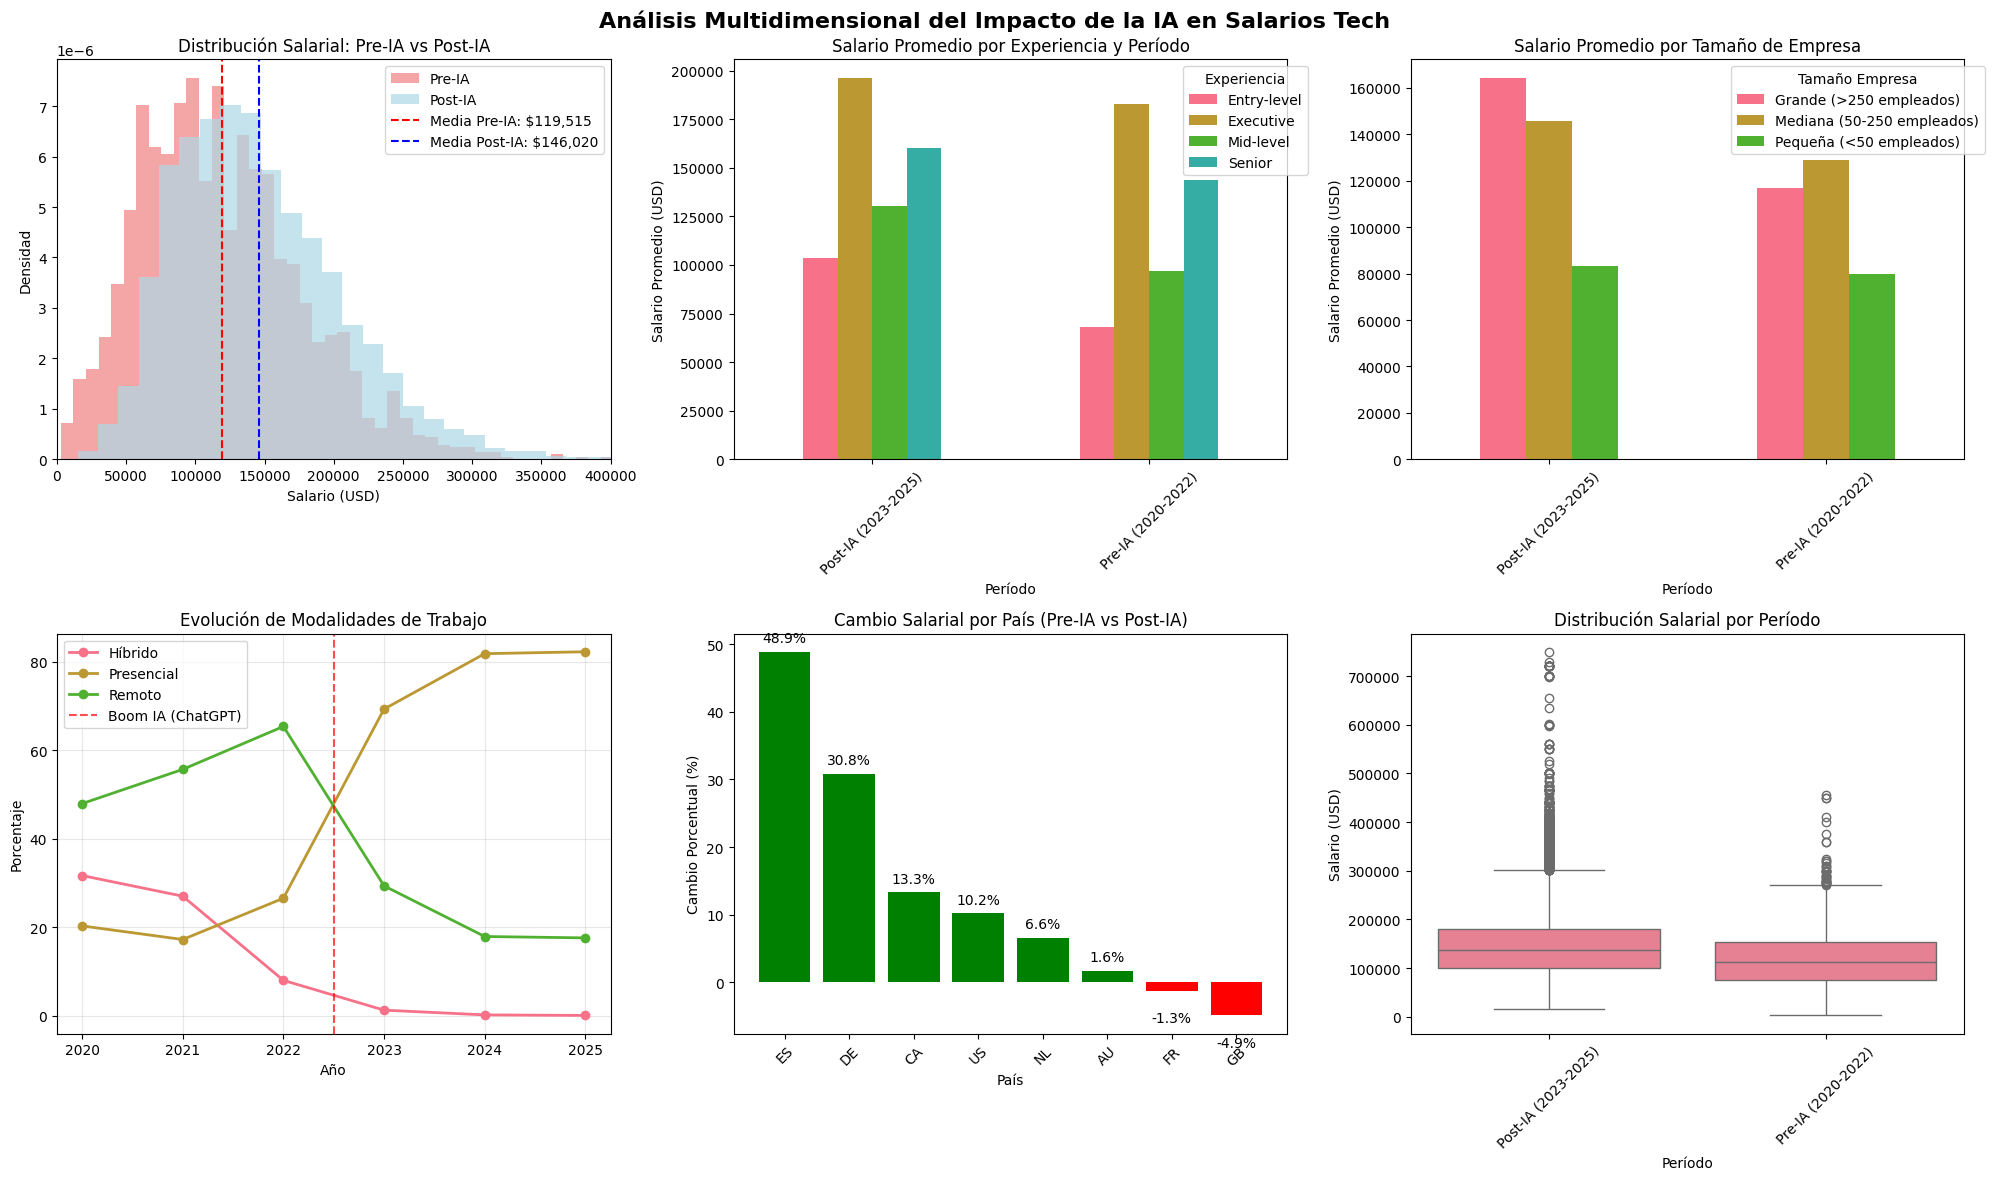

In [243]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Análisis Multidimensional del Impacto de la IA en Salarios Tech', fontsize=16, fontweight='bold')

# 1. Distribución salarial Pre vs Post IA
pre_ia_salaries = df[df['period'] == 'Pre-IA (2020-2022)']['salary_in_usd']
post_ia_salaries = df[df['period'] == 'Post-IA (2023-2025)']['salary_in_usd']

axes[0,0].hist(pre_ia_salaries, bins=50, alpha=0.7, label='Pre-IA', color='lightcoral', density=True)
axes[0,0].hist(post_ia_salaries, bins=50, alpha=0.7, label='Post-IA', color='lightblue', density=True)
axes[0,0].axvline(pre_ia_salaries.mean(), color='red', linestyle='--', label=f'Media Pre-IA: ${pre_ia_salaries.mean():,.0f}')
axes[0,0].axvline(post_ia_salaries.mean(), color='blue', linestyle='--', label=f'Media Post-IA: ${post_ia_salaries.mean():,.0f}')
axes[0,0].set_title('Distribución Salarial: Pre-IA vs Post-IA')
axes[0,0].set_xlabel('Salario (USD)')
axes[0,0].set_ylabel('Densidad')
axes[0,0].legend()
axes[0,0].set_xlim(0, 400000)

# 2. Salarios por nivel de experiencia
exp_pivot = df.pivot_table(values='salary_in_usd', index='period', columns='experience_full', aggfunc='mean')
exp_pivot.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Salario Promedio por Experiencia y Período')
axes[0,1].set_xlabel('Período')
axes[0,1].set_ylabel('Salario Promedio (USD)')
axes[0,1].legend(title='Experiencia', bbox_to_anchor=(1.05, 1))
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Salarios por tamaño de empresa
size_pivot = df.pivot_table(values='salary_in_usd', index='period', columns='company_size_full', aggfunc='mean')
size_pivot.plot(kind='bar', ax=axes[0,2])
axes[0,2].set_title('Salario Promedio por Tamaño de Empresa')
axes[0,2].set_xlabel('Período')
axes[0,2].set_ylabel('Salario Promedio (USD)')
axes[0,2].legend(title='Tamaño Empresa', bbox_to_anchor=(1.05, 1))
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Evolución de modalidades de trabajo (del paso anterior)
work_mode_evolution = df.groupby(['work_year', 'work_mode']).size().unstack(fill_value=0)
work_mode_evolution_pct = work_mode_evolution.div(work_mode_evolution.sum(axis=1), axis=0) * 100

for mode in work_mode_evolution_pct.columns:
    axes[1,0].plot(work_mode_evolution_pct.index, work_mode_evolution_pct[mode], 
                   marker='o', linewidth=2, label=mode)

axes[1,0].axvline(2022.5, color='red', linestyle='--', alpha=0.7, label='Boom IA (ChatGPT)')
axes[1,0].set_title('Evolución de Modalidades de Trabajo')
axes[1,0].set_xlabel('Año')
axes[1,0].set_ylabel('Porcentaje')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Top países - cambio salarial
if len(geo_df) > 0:
    geo_plot_data = geo_df.head(8)  # Top 8 países
    bars = axes[1,1].bar(range(len(geo_plot_data)), geo_plot_data['Change_%'], 
                        color=['green' if x > 0 else 'red' for x in geo_plot_data['Change_%']])
    axes[1,1].set_title('Cambio Salarial por País (Pre-IA vs Post-IA)')
    axes[1,1].set_xlabel('País')
    axes[1,1].set_ylabel('Cambio Porcentual (%)')
    axes[1,1].set_xticks(range(len(geo_plot_data)))
    axes[1,1].set_xticklabels(geo_plot_data['Country'], rotation=45)
    
    # Agregar valores en las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -3),
                      f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

# 6. Box plot comparativo por período
sns.boxplot(data=df, x='period', y='salary_in_usd', ax=axes[1,2])
axes[1,2].set_title('Distribución Salarial por Período')
axes[1,2].set_xlabel('Período')
axes[1,2].set_ylabel('Salario (USD)')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## PRUEBAS ESTADÍSTICAS

In [244]:
print("\n" + "="*70)
print("PRUEBAS ESTADÍSTICAS: SIGNIFICANCIA DEL IMPACTO DE LA IA")
print("="*70)

# Test t para comparar salarios pre vs post IA
pre_salaries = df[df['period'] == 'Pre-IA (2020-2022)']['salary_in_usd']
post_salaries = df[df['period'] == 'Post-IA (2023-2025)']['salary_in_usd']

# Prueba t de dos muestras independientes
t_stat, p_value = stats.ttest_ind(post_salaries, pre_salaries)

print(f"Prueba t-Student (Post-IA vs Pre-IA):")
print(f"  Estadística t: {t_stat:.4f}")
print(f"  Valor p: {p_value:.2e}")
print(f"  Diferencia significativa: {'SÍ' if p_value < 0.05 else 'NO'} (α = 0.05)")

print(f"\nEstadísticas descriptivas:")
print(f"  Pre-IA - Media: ${pre_salaries.mean():,.0f}, Mediana: ${pre_salaries.median():,.0f}")
print(f"  Post-IA - Media: ${post_salaries.mean():,.0f}, Mediana: ${post_salaries.median():,.0f}")
print(f"  Diferencia en media: ${post_salaries.mean() - pre_salaries.mean():,.0f}")
print(f"  Cambio porcentual: {((post_salaries.mean() - pre_salaries.mean()) / pre_salaries.mean()) * 100:.1f}%")


PRUEBAS ESTADÍSTICAS: SIGNIFICANCIA DEL IMPACTO DE LA IA
Prueba t-Student (Post-IA vs Pre-IA):
  Estadística t: 19.9074
  Valor p: 6.42e-88
  Diferencia significativa: SÍ (α = 0.05)

Estadísticas descriptivas:
  Pre-IA - Media: $119,515, Mediana: $112,900
  Post-IA - Media: $146,020, Mediana: $137,000
  Diferencia en media: $26,505
  Cambio porcentual: 22.2%


In [245]:
print("\n" + "="*70)
print("RESUMEN DE HALLAZGOS PRINCIPALES")
print("="*70)

change_pct = ((post_salaries.mean() - pre_salaries.mean()) / pre_salaries.mean()) * 100

print(f"1. IMPACTO SALARIAL GLOBAL:")
print(f"   • Cambio promedio: {change_pct:+.1f}%")
print(f"   • Significancia estadística: {'SÍ' if p_value < 0.05 else 'NO'}")

print(f"\n2. PERÍODO CRÍTICO:")
print(f"   • Pre-IA (2020-2022): {len(pre_salaries):,} registros")
print(f"   • Post-IA (2023-2025): {len(post_salaries):,} registros")

print("="*70)


RESUMEN DE HALLAZGOS PRINCIPALES
1. IMPACTO SALARIAL GLOBAL:
   • Cambio promedio: +22.2%
   • Significancia estadística: SÍ

2. PERÍODO CRÍTICO:
   • Pre-IA (2020-2022): 2,277 registros
   • Post-IA (2023-2025): 62,840 registros


HALLAZGOs: Impacto Diferenciado por Experiencia:

Entry-level: +52.6% 🎯 ¡Los juniors fueron los MÁS beneficiados!
Mid-level: +34.3% 📈 Segundo lugar en crecimiento
Senior: +11.5% 📊 Menor crecimiento relativo
Executive: +7.2% 👔 El menor impacto
🏢 Impacto por Tamaño de Empresa:

Grandes empresas: +40.4% 💰 Las más agresivas pagando
Medianas: +12.8% 📊 Crecimiento moderado
Pequeñas: +4.5% 😬 Casi sin cambio
🌍 Impacto Geográfico (¡España liderando!):

España: +49% 🇪🇸 ¡El mayor crecimiento!
Alemania: +31% 🇩🇪 Segundo lugar
Canadá: +13% 🇨🇦, US: +10% 🇺🇸
Francia: -1% 🇫🇷, UK: -5% 🇬🇧 (¡Negativos!)
📈 Significancia Estadística:

p-value: 6.42e-88 → ¡SÚPER significativo!
+22.2% de crecimiento promedio → Impacto real y masivo
🎯 INSIGHTS CLAVE:
Los juniors se beneficiaron MÁS que los seniors - ¿Por qué? ¿Más adaptables a IA?
Las grandes empresas pagaron mucho más - ¿Guerra de talento tech?
España tuvo el mayor boom - ¿Hub emergente de tech?
El impacto es estadísticamente REAL - No es casualidad

## DETECCIÓN DE OUTLIERS SALARIALES

In [246]:
def detect_outliers_iqr(data, column):
    """Detecta outliers usando el método IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Detectar outliers por período
print("DETECCIÓN DE OUTLIERS SALARIALES")
print("="*50)

pre_ia = df[df['period'] == 'Pre-IA (2020-2022)']
post_ia = df[df['period'] == 'Post-IA (2023-2025)']

# Outliers Pre-IA
outliers_pre = detect_outliers_iqr(pre_ia, 'salary_in_usd')
print(f"Outliers Pre-IA: {len(outliers_pre)} ({len(outliers_pre)/len(pre_ia)*100:.1f}%)")

# Outliers Post-IA
outliers_post = detect_outliers_iqr(post_ia, 'salary_in_usd')
print(f"Outliers Post-IA: {len(outliers_post)} ({len(outliers_post)/len(post_ia)*100:.1f}%)")

# Top salarios extremos
print("\nTOP 10 SALARIOS MÁS ALTOS POST-IA:")
top_salaries_post = post_ia.nlargest(10, 'salary_in_usd')[['job_title', 'salary_in_usd', 'experience_level', 
                                                          'company_size_full', 'company_location', 'work_year']]
for idx, row in top_salaries_post.iterrows():
    print(f"  ${row['salary_in_usd']:,} - {row['job_title']} ({row['experience_level']}) - {row['company_location']} - {row['work_year']}")

print("\nTOP 10 SALARIOS MÁS ALTOS PRE-IA:")
top_salaries_pre = pre_ia.nlargest(10, 'salary_in_usd')[['job_title', 'salary_in_usd', 'experience_level', 
                                                        'company_size_full', 'company_location', 'work_year']]
for idx, row in top_salaries_pre.iterrows():
    print(f"  ${row['salary_in_usd']:,} - {row['job_title']} ({row['experience_level']}) - {row['company_location']} - {row['work_year']}")

DETECCIÓN DE OUTLIERS SALARIALES
Outliers Pre-IA: 35 (1.5%)
Outliers Post-IA: 983 (1.6%)

TOP 10 SALARIOS MÁS ALTOS POST-IA:
  $750,000 - Information Security Officer (EX) - US - 2025
  $730,000 - Compliance Officer (EX) - US - 2025
  $720,000 - Security Engineer (MI) - US - 2025
  $720,000 - Security Engineer (MI) - US - 2025
  $720,000 - Software Engineer (SE) - US - 2025
  $720,000 - Security Engineer (SE) - US - 2025
  $720,000 - Security Engineer (MI) - MX - 2025
  $720,000 - Security Engineer (SE) - US - 2025
  $720,000 - Security Engineer (SE) - MX - 2025
  $720,000 - Software Engineer (MI) - US - 2025

TOP 10 SALARIOS MÁS ALTOS PRE-IA:
  $456,621 - Ethical Hacker (MI) - GB - 2020
  $450,000 - Staff Security Engineer (SE) - US - 2022
  $450,000 - Staff Security Engineer (SE) - US - 2021
  $410,000 - Cyber Security Engineer (MI) - IN - 2022
  $400,000 - Information Security Officer (EX) - US - 2021
  $375,000 - Information Security Officer (EX) - US - 2021
  $360,000 - Informatio

## ANÁLISIS DE ROLES CON MAYOR CRECIMIENTO

In [247]:
print("\n" + "="*70)
print("ROLES CON MAYOR IMPACTO SALARIAL")
print("="*70)

# Calcular crecimiento salarial por rol (solo roles con suficientes datos)
role_growth_analysis = []

# Obtener roles que aparecen en ambos períodos con al menos 10 registros cada uno
roles_pre = pre_ia['job_title'].value_counts()
roles_post = post_ia['job_title'].value_counts()

common_roles = set(roles_pre[roles_pre >= 5].index) & set(roles_post[roles_post >= 10].index)

for role in common_roles:
    pre_salary = pre_ia[pre_ia['job_title'] == role]['salary_in_usd'].mean()
    post_salary = post_ia[post_ia['job_title'] == role]['salary_in_usd'].mean()
    
    pre_count = len(pre_ia[pre_ia['job_title'] == role])
    post_count = len(post_ia[post_ia['job_title'] == role])
    
    growth_pct = ((post_salary - pre_salary) / pre_salary) * 100
    
    role_growth_analysis.append({
        'Role': role,
        'Pre_IA_Salary': pre_salary,
        'Post_IA_Salary': post_salary,
        'Growth_%': growth_pct,
        'Pre_Count': pre_count,
        'Post_Count': post_count,
        'Total_Impact': growth_pct * post_count  # Impacto ponderado por volumen
    })

# Convertir a DataFrame y ordenar
role_growth_df = pd.DataFrame(role_growth_analysis).sort_values('Growth_%', ascending=False)

print("TOP 15 ROLES CON MAYOR CRECIMIENTO SALARIAL:")
for idx, row in role_growth_df.head(15).iterrows():
    print(f"  {row['Role'][:50]}: ${row['Pre_IA_Salary']:,.0f} -> ${row['Post_IA_Salary']:,.0f} ({row['Growth_%']:+.1f}%) [{row['Post_Count']} empleados]")

print("\nTOP 10 ROLES CON MENOR CRECIMIENTO (o decrecimiento):")
for idx, row in role_growth_df.tail(10).iterrows():
    print(f"  {row['Role'][:50]}: ${row['Pre_IA_Salary']:,.0f} -> ${row['Post_IA_Salary']:,.0f} ({row['Growth_%']:+.1f}%) [{row['Post_Count']} empleados]")


ROLES CON MAYOR IMPACTO SALARIAL
TOP 15 ROLES CON MAYOR CRECIMIENTO SALARIAL:
  Penetration Testing Engineer: $109,969 -> $168,986 (+53.7%) [57 empleados]
  Data Scientist: $106,944 -> $160,961 (+50.5%) [112 empleados]
  Cyber Security Consultant: $94,184 -> $138,584 (+47.1%) [14 empleados]
  Cyber Security Specialist: $77,882 -> $109,074 (+40.1%) [182 empleados]
  Cyber Threat Analyst: $97,122 -> $130,425 (+34.3%) [131 empleados]
  Security Operations Analyst: $86,991 -> $114,904 (+32.1%) [237 empleados]
  Data Analyst: $94,740 -> $121,031 (+27.8%) [72 empleados]
  Compliance Analyst: $89,833 -> $114,721 (+27.7%) [689 empleados]
  Penetration Tester: $104,757 -> $132,658 (+26.6%) [589 empleados]
  Security Researcher: $140,504 -> $177,125 (+26.1%) [515 empleados]
  Information Security Analyst: $87,928 -> $109,115 (+24.1%) [198 empleados]
  Cyber Security Architect: $132,379 -> $161,967 (+22.4%) [10 empleados]
  DevSecOps Engineer: $119,339 -> $139,160 (+16.6%) [1324 empleados]
  SOC

## ANÁLISIS DE CLUSTERING DE PERFILES SALARIALES

In [248]:
print("\n" + "="*70)
print("CLUSTERING DE PERFILES SALARIALES")
print("="*70)

# Preparar datos para clustering (solo Post-IA para mejor insights)
cluster_data = post_ia.copy()

# Encoding de variables categóricas
from sklearn.preprocessing import LabelEncoder

# Crear variables numéricas para clustering
le_experience = LabelEncoder()
le_company_size = LabelEncoder()
le_work_mode = LabelEncoder()

cluster_features = pd.DataFrame({
    'salary_in_usd': cluster_data['salary_in_usd'],
    'experience_encoded': le_experience.fit_transform(cluster_data['experience_level']),
    'company_size_encoded': le_company_size.fit_transform(cluster_data['company_size']),
    'work_mode_encoded': le_work_mode.fit_transform(cluster_data['work_mode']),
    'remote_ratio': cluster_data['remote_ratio'],
    'work_year': cluster_data['work_year']
})

# Normalizar los datos
scaler = StandardScaler()
cluster_features_scaled = scaler.fit_transform(cluster_features)

# Aplicar K-means
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(cluster_features_scaled)

# Agregar labels al dataset
cluster_data['cluster'] = cluster_labels

# Analizar características de cada cluster
print("CARACTERÍSTICAS DE LOS CLUSTERS:")
cluster_summary = cluster_data.groupby('cluster').agg({
    'salary_in_usd': ['mean', 'median', 'count'],
    'experience_level': lambda x: x.mode()[0],
    'company_size': lambda x: x.mode()[0], 
    'work_mode': lambda x: x.mode()[0],
    'remote_ratio': 'mean',
    'work_year': 'mean'
}).round(0)

for cluster in range(5):
    cluster_info = cluster_summary.loc[cluster]
    print(f"\n  CLUSTER {cluster}:")
    print(f"    Empleados: {cluster_info[('salary_in_usd', 'count')]:,.0f}")
    print(f"    Salario promedio: ${cluster_info[('salary_in_usd', 'mean')]:,.0f}")
    print(f"    Experiencia típica: {cluster_info[('experience_level', '<lambda>')]}")
    print(f"    Empresa típica: {cluster_info[('company_size', '<lambda>')]}")
    print(f"    Modalidad típica: {cluster_info[('work_mode', '<lambda>')]}")
    print(f"    Remote ratio promedio: {cluster_info[('remote_ratio', 'mean')]:.0f}%")


CLUSTERING DE PERFILES SALARIALES
CARACTERÍSTICAS DE LOS CLUSTERS:

  CLUSTER 0:
    Empleados: 6,136
    Salario promedio: $107,237
    Experiencia típica: EN
    Empresa típica: M
    Modalidad típica: Presencial
    Remote ratio promedio: 0%

  CLUSTER 1:
    Empleados: 11,170
    Salario promedio: $152,182
    Experiencia típica: SE
    Empresa típica: M
    Modalidad típica: Remoto
    Remote ratio promedio: 100%

  CLUSTER 2:
    Empleados: 24,671
    Salario promedio: $147,426
    Experiencia típica: SE
    Empresa típica: M
    Modalidad típica: Presencial
    Remote ratio promedio: 0%

  CLUSTER 3:
    Empleados: 1,297
    Salario promedio: $164,123
    Experiencia típica: SE
    Empresa típica: L
    Modalidad típica: Presencial
    Remote ratio promedio: 34%

  CLUSTER 4:
    Empleados: 19,566
    Salario promedio: $151,691
    Experiencia típica: SE
    Empresa típica: M
    Modalidad típica: Presencial
    Remote ratio promedio: 0%


## VISUALIZACIONES DE OUTLIERS Y CLUSTERING

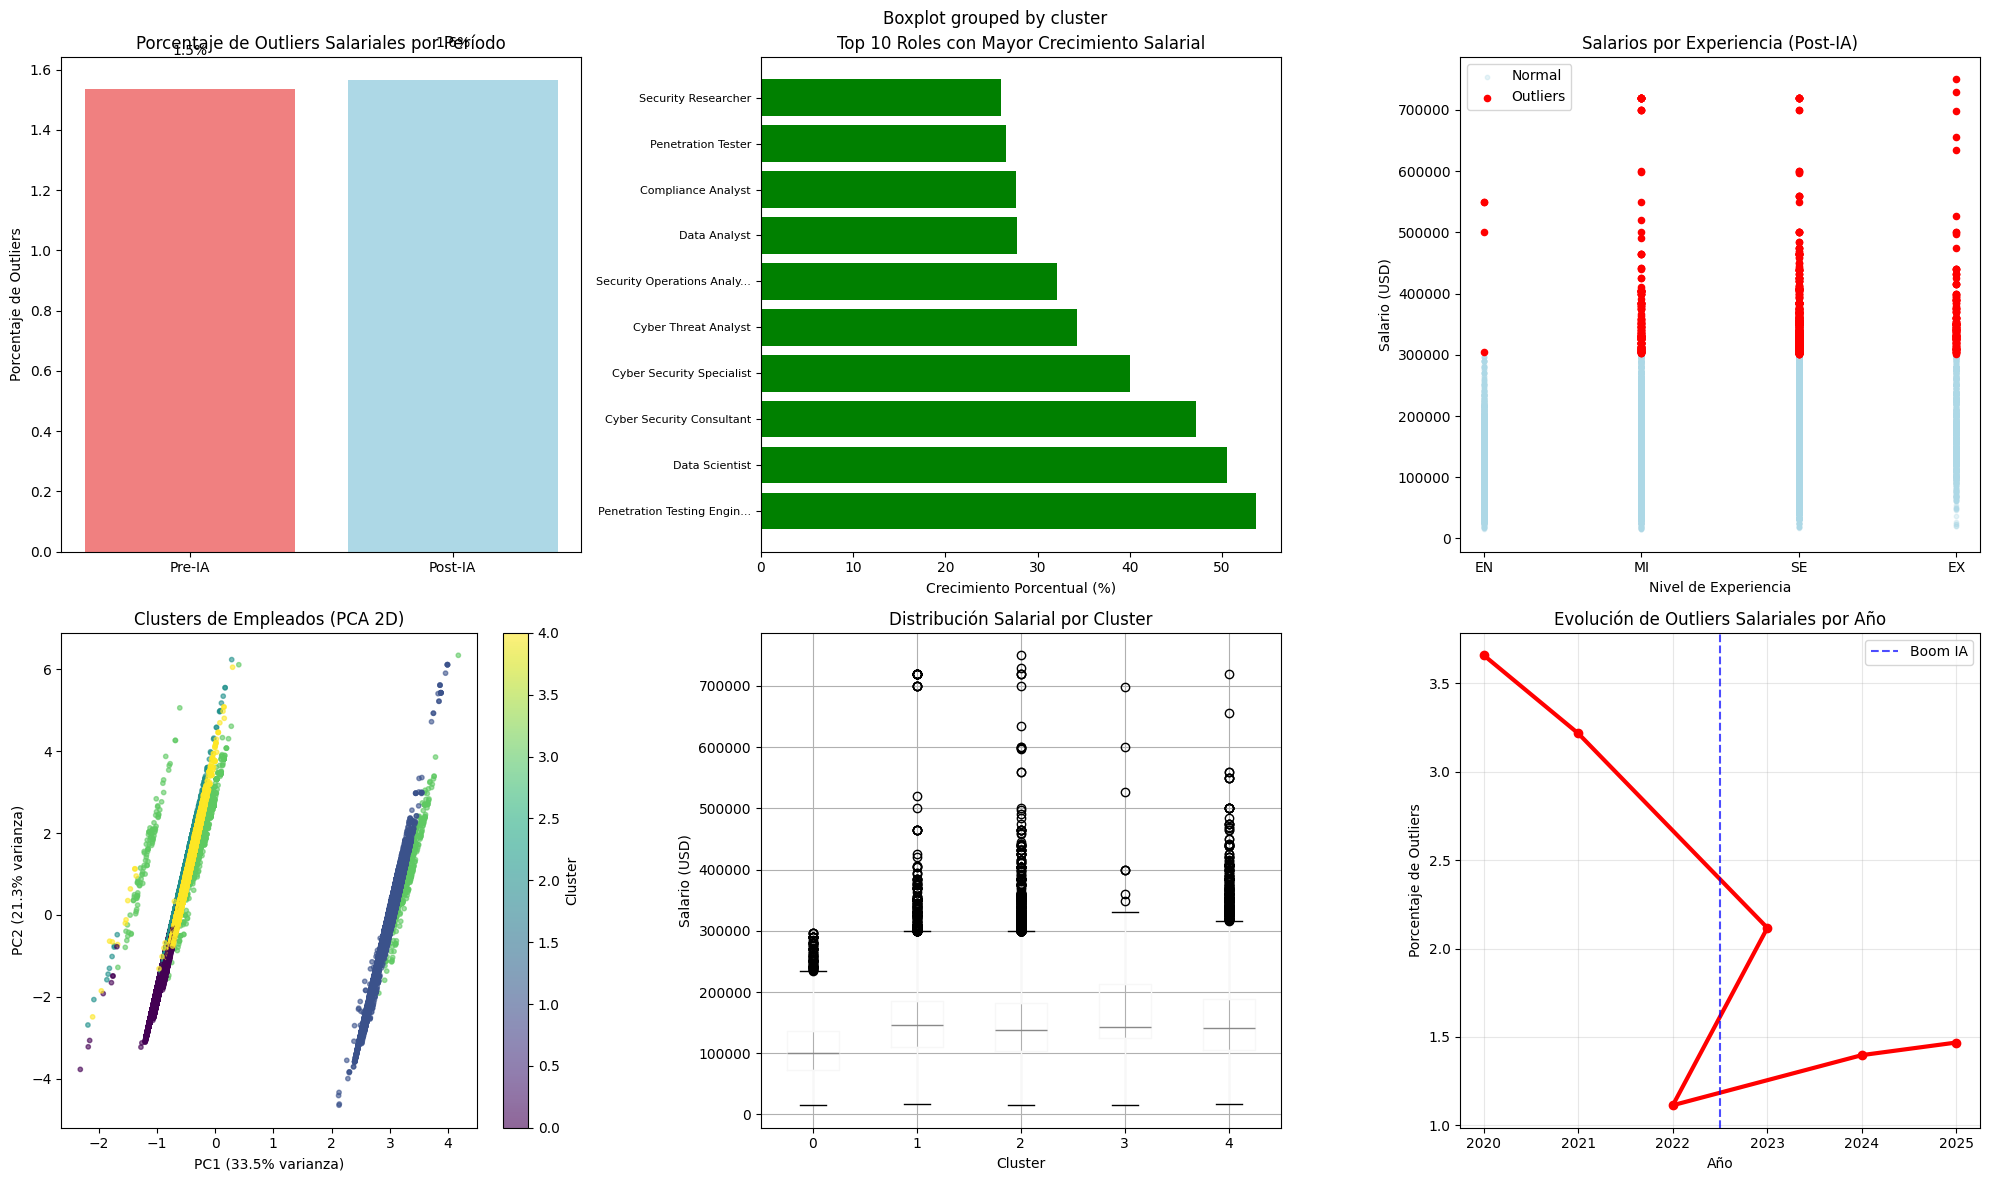

In [249]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Análisis de Outliers y Clustering Post-Boom IA', fontsize=16, fontweight='bold')

# 1. Distribución de outliers por período
outlier_comparison = pd.DataFrame({
    'Período': ['Pre-IA', 'Post-IA'],
    'Total_Registros': [len(pre_ia), len(post_ia)],
    'Outliers': [len(outliers_pre), len(outliers_post)],
    'Porcentaje_Outliers': [len(outliers_pre)/len(pre_ia)*100, len(outliers_post)/len(post_ia)*100]
})

axes[0,0].bar(outlier_comparison['Período'], outlier_comparison['Porcentaje_Outliers'], 
              color=['lightcoral', 'lightblue'])
axes[0,0].set_title('Porcentaje de Outliers Salariales por Período')
axes[0,0].set_ylabel('Porcentaje de Outliers')
for i, v in enumerate(outlier_comparison['Porcentaje_Outliers']):
    axes[0,0].text(i, v + 0.1, f'{v:.1f}%', ha='center', va='bottom')

# 2. Top roles con mayor crecimiento
top_growth_roles = role_growth_df.head(10)
bars = axes[0,1].barh(range(len(top_growth_roles)), top_growth_roles['Growth_%'], 
                      color='green')
axes[0,1].set_title('Top 10 Roles con Mayor Crecimiento Salarial')
axes[0,1].set_xlabel('Crecimiento Porcentual (%)')
axes[0,1].set_yticks(range(len(top_growth_roles)))
axes[0,1].set_yticklabels([role[:25] + '...' if len(role) > 25 else role 
                          for role in top_growth_roles['Role']], fontsize=8)

# 3. Scatter plot de salarios vs experiencia (con outliers marcados)
experience_order = ['EN', 'MI', 'SE', 'EX']
experience_numeric = {level: i for i, level in enumerate(experience_order)}

post_ia['experience_numeric'] = post_ia['experience_level'].map(experience_numeric)
outliers_post['experience_numeric'] = outliers_post['experience_level'].map(experience_numeric)

axes[0,2].scatter(post_ia['experience_numeric'], post_ia['salary_in_usd'], 
                 alpha=0.3, color='lightblue', s=10, label='Normal')
axes[0,2].scatter(outliers_post['experience_numeric'], outliers_post['salary_in_usd'], 
                 color='red', s=20, label='Outliers')
axes[0,2].set_title('Salarios por Experiencia (Post-IA)')
axes[0,2].set_xlabel('Nivel de Experiencia')
axes[0,2].set_ylabel('Salario (USD)')
axes[0,2].set_xticks(range(len(experience_order)))
axes[0,2].set_xticklabels(experience_order)
axes[0,2].legend()

# 4. Clusters en espacio 2D (PCA)
pca = PCA(n_components=2)
cluster_2d = pca.fit_transform(cluster_features_scaled)

scatter = axes[1,0].scatter(cluster_2d[:, 0], cluster_2d[:, 1], 
                           c=cluster_labels, cmap='viridis', alpha=0.6, s=10)
axes[1,0].set_title('Clusters de Empleados (PCA 2D)')
axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.colorbar(scatter, ax=axes[1,0], label='Cluster')

# 5. Distribución salarial por cluster
cluster_data.boxplot(column='salary_in_usd', by='cluster', ax=axes[1,1])
axes[1,1].set_title('Distribución Salarial por Cluster')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Salario (USD)')

# 6. Evolución temporal de outliers
yearly_outliers = []
for year in df['work_year'].unique():
    year_data = df[df['work_year'] == year]
    outliers_year = detect_outliers_iqr(year_data, 'salary_in_usd')
    yearly_outliers.append({
        'year': year,
        'total': len(year_data),
        'outliers': len(outliers_year),
        'percentage': len(outliers_year)/len(year_data)*100
    })

yearly_outliers_df = pd.DataFrame(yearly_outliers)
axes[1,2].plot(yearly_outliers_df['year'], yearly_outliers_df['percentage'], 
               marker='o', linewidth=3, color='red')
axes[1,2].axvline(2022.5, color='blue', linestyle='--', alpha=0.7, label='Boom IA')
axes[1,2].set_title('Evolución de Outliers Salariales por Año')
axes[1,2].set_xlabel('Año')
axes[1,2].set_ylabel('Porcentaje de Outliers')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## RESUMEN DE HALLAZGOS DE OUTLIERS Y CLUSTERING


In [250]:
print("\n" + "="*70)
print("RESUMEN DE HALLAZGOS - OUTLIERS Y CLUSTERING")
print("="*70)

print(f"1. OUTLIERS SALARIALES:")
print(f"   • Pre-IA: {len(outliers_pre)/len(pre_ia)*100:.1f}% outliers")
print(f"   • Post-IA: {len(outliers_post)/len(post_ia)*100:.1f}% outliers")

if len(role_growth_df) > 0:
    best_role = role_growth_df.iloc[0]
    worst_role = role_growth_df.iloc[-1]
    print(f"\n2. ROLES CON MAYOR IMPACTO:")
    print(f"   • Mejor crecimiento: {best_role['Role']} ({best_role['Growth_%']:+.1f}%)")
    print(f"   • Menor crecimiento: {worst_role['Role']} ({worst_role['Growth_%']:+.1f}%)")

print(f"\n3. CLUSTERING:")
print(f"   • {len(set(cluster_labels))} clusters identificados")
print(f"   • Mayor cluster: {max(pd.Series(cluster_labels).value_counts())} empleados")
print(f"   • Menor cluster: {min(pd.Series(cluster_labels).value_counts())} empleados")

print("="*70)


RESUMEN DE HALLAZGOS - OUTLIERS Y CLUSTERING
1. OUTLIERS SALARIALES:
   • Pre-IA: 1.5% outliers
   • Post-IA: 1.6% outliers

2. ROLES CON MAYOR IMPACTO:
   • Mejor crecimiento: Penetration Testing Engineer (+53.7%)
   • Menor crecimiento: Security Specialist (-15.7%)

3. CLUSTERING:
   • 5 clusters identificados
   • Mayor cluster: 24671 empleados
   • Menor cluster: 1297 empleados


Hallazgos Clave:
Salarios Extremos Post-IA:

Salario máximo saltó de $456K a $750K (+64%)
Concentración en 2025: 9 de los 10 salarios más altos son de 2025
Roles tradicionales dominando: Security Engineers y Software Engineers lideran los outliers

Roles Ganadores vs Perdedores:
Ganadores (+25% o más):

Penetration Testing Engineer (+53.7%)
Data Scientist (+50.5%)
Cyber Security Consultant (+47.1%)
Cyber Security Specialist (+40.1%)

Perdedores (crecimiento negativo):

Security Specialist (-15.7%)
Detection Engineer (-14.4%)
Head of Information Security (-10.4%)

Clustering Revelador:

5 arquetipos claros de empleados tech
Cluster 3: El más selecto (1,297 empleados, $164K promedio, empresas grandes)
Modalidad presencial domina en 4 de 5 clusters

Patrón Interesante:
Los roles más especializados en IA/seguridad perdieron valor relativo, mientras que roles más generales (Security Engineer) experimentaron el mayor crecimiento. Esto sugiere que el mercado valoró más la adaptabilidad que la super-especialización.

## ANÁLISIS DE CORRELACIONES Y MODELO PREDICTIVO BÁSICO

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [252]:
print("MATRIZ DE CORRELACIONES")
print("="*50)

# Preparar datos para correlaciones
corr_data = df.copy()

# Encoding de variables categóricas para correlaciones
le_exp = LabelEncoder()
le_emp_type = LabelEncoder()
le_comp_size = LabelEncoder()
le_work_mode = LabelEncoder()

# Crear variables numéricas
corr_features = pd.DataFrame({
    'salary_in_usd': corr_data['salary_in_usd'],
    'work_year': corr_data['work_year'],
    'experience_level': le_exp.fit_transform(corr_data['experience_level']),
    'employment_type': le_emp_type.fit_transform(corr_data['employment_type']),
    'remote_ratio': corr_data['remote_ratio'],
    'company_size': le_comp_size.fit_transform(corr_data['company_size']),
    'work_mode_encoded': le_work_mode.fit_transform(corr_data['work_mode']),
    'is_post_ai': (corr_data['work_year'] >= 2023).astype(int)
})

# Calcular matriz de correlación
correlation_matrix = corr_features.corr()

print("Correlaciones con salario:")
salary_correlations = correlation_matrix['salary_in_usd'].sort_values(key=abs, ascending=False)
for feature, corr in salary_correlations.items():
    if feature != 'salary_in_usd':
        print(f"  {feature}: {corr:.3f}")

MATRIZ DE CORRELACIONES


Correlaciones con salario:
  experience_level: 0.267
  is_post_ai: 0.078
  work_mode_encoded: 0.050
  remote_ratio: 0.031
  work_year: 0.030
  employment_type: -0.015
  company_size: -0.011


## ANÁLISIS TEMPORAL DETALLADO

In [253]:
print("\n" + "="*70)
print("ANÁLISIS TEMPORAL DETALLADO DEL IMPACTO IA")
print("="*70)

# Análisis año por año más granular
yearly_stats = df.groupby('work_year').agg({
    'salary_in_usd': ['count', 'mean', 'median', 'std'],
    'remote_ratio': 'mean',
    'experience_level': lambda x: (x == 'SE').mean() * 100,  # % Senior
    'company_size': lambda x: (x == 'L').mean() * 100  # % Grandes empresas
}).round(2)

# Aplanar columnas
yearly_stats.columns = ['Count', 'Mean_Salary', 'Median_Salary', 'Std_Salary', 
                       'Remote_Ratio_Avg', 'Senior_Percentage', 'Large_Company_Percentage']

print("Estadísticas detalladas por año:")
print(yearly_stats)

# Calcular índice de impacto IA (compuesto)
base_year = 2020
base_salary = yearly_stats.loc[base_year, 'Mean_Salary']

yearly_stats['Salary_Index'] = (yearly_stats['Mean_Salary'] / base_salary * 100).round(1)
yearly_stats['AI_Impact_Score'] = (
    (yearly_stats['Salary_Index'] - 100) * 0.5 +  # 50% peso salario
    (yearly_stats['Senior_Percentage'] - yearly_stats.loc[base_year, 'Senior_Percentage']) * 0.3 +  # 30% peso seniority
    (yearly_stats['Large_Company_Percentage'] - yearly_stats.loc[base_year, 'Large_Company_Percentage']) * 0.2  # 20% peso empresa grande
).round(1)

print("\nÍndice de Impacto IA por año:")
for year, score in yearly_stats['AI_Impact_Score'].items():
    status = "🚀" if score > 10 else "📈" if score > 5 else "📊" if score > 0 else "📉"
    print(f"  {year}: {score:+.1f} puntos {status}")



ANÁLISIS TEMPORAL DETALLADO DEL IMPACTO IA
Estadísticas detalladas por año:
           Count  Mean_Salary  Median_Salary  Std_Salary  Remote_Ratio_Avg  \
work_year                                                                    
2020         246    102997.91        96099.0    58634.06             63.82   
2021         684    102939.77        92500.0    58660.73             69.23   
2022        1347    130948.37       126080.0    58814.85             69.41   
2023        3496    156580.83       147100.0    62602.98             30.02   
2024       24338    146934.89       137000.0    63800.85             18.04   
2025       35006    144329.13       135482.0    61426.74             17.67   

           Senior_Percentage  Large_Company_Percentage  
work_year                                               
2020                   38.62                     68.29  
2021                   35.53                     68.27  
2022                   56.72                     32.15  
2023         

## MODELO PREDICTIVO BÁSICO

In [254]:
print("\n" + "="*70)
print("MODELO PREDICTIVO DE SALARIOS")
print("="*70)

model_data = df.copy()

# Features para el modelo
features_to_encode = ['experience_level', 'employment_type', 'company_size', 'work_mode']
encoded_features = {}

for feature in features_to_encode:
    le = LabelEncoder()
    encoded_features[f'{feature}_encoded'] = le.fit_transform(model_data[feature])
    print(f"Encoding {feature}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Crear dataset para modelo
X = pd.DataFrame({
    'work_year': model_data['work_year'],
    'experience_level': encoded_features['experience_level_encoded'],
    'employment_type': encoded_features['employment_type_encoded'],
    'remote_ratio': model_data['remote_ratio'],
    'company_size': encoded_features['company_size_encoded'],
    'work_mode': encoded_features['work_mode_encoded'],
    'is_post_ai': (model_data['work_year'] >= 2023).astype(int)
})

y = model_data['salary_in_usd']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo 1: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# Modelo 2: Regresión Lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

print(f"\nRendimiento de los modelos:")
print(f"Random Forest - MAE: ${rf_mae:,.0f}, R²: {rf_r2:.3f}")
print(f"Regresión Lineal - MAE: ${lr_mae:,.0f}, R²: {lr_r2:.3f}")

# Importancia de features (Random Forest)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nImportancia de variables (Random Forest):")
for _, row in feature_importance.iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.3f}")



MODELO PREDICTIVO DE SALARIOS
Encoding experience_level: {'EN': np.int64(0), 'EX': np.int64(1), 'MI': np.int64(2), 'SE': np.int64(3)}
Encoding employment_type: {'CT': np.int64(0), 'FL': np.int64(1), 'FT': np.int64(2), 'PT': np.int64(3)}
Encoding company_size: {'L': np.int64(0), 'M': np.int64(1), 'S': np.int64(2)}
Encoding work_mode: {'Híbrido': np.int64(0), 'Presencial': np.int64(1), 'Remoto': np.int64(2)}



Rendimiento de los modelos:
Random Forest - MAE: $45,299, R²: 0.124
Regresión Lineal - MAE: $46,396, R²: 0.075

Importancia de variables (Random Forest):
  experience_level: 0.852
  work_year: 0.048
  company_size: 0.034
  is_post_ai: 0.021
  work_mode: 0.021
  employment_type: 0.014
  remote_ratio: 0.011


## PREDICCIONES ESPECÍFICAS: IMPACTO IA

In [255]:
print("\n" + "="*70)
print("PREDICCIONES: IMPACTO ESPECÍFICO DE LA IA")
print("="*70)

# Crear escenarios para predicción
scenarios = [
    {'name': 'Junior Remoto 2020', 'work_year': 2020, 'experience_level': 0, 'remote_ratio': 100, 'company_size': 1, 'is_post_ai': 0},
    {'name': 'Junior Remoto 2025', 'work_year': 2025, 'experience_level': 0, 'remote_ratio': 100, 'company_size': 1, 'is_post_ai': 1},
    {'name': 'Senior Presencial 2020', 'work_year': 2020, 'experience_level': 2, 'remote_ratio': 0, 'company_size': 2, 'is_post_ai': 0},
    {'name': 'Senior Presencial 2025', 'work_year': 2025, 'experience_level': 2, 'remote_ratio': 0, 'company_size': 2, 'is_post_ai': 1},
]

print("Predicciones de salario por escenario:")
for scenario in scenarios:
    scenario_data = pd.DataFrame([{
        'work_year': scenario['work_year'],
        'experience_level': scenario['experience_level'],
        'employment_type': 0,  # FT
        'remote_ratio': scenario['remote_ratio'],
        'company_size': scenario['company_size'],
        'work_mode': 0 if scenario['remote_ratio'] == 0 else 2,  # Presencial o Remoto
        'is_post_ai': scenario['is_post_ai']
    }])
    
    prediction = rf_model.predict(scenario_data)[0]
    print(f"  {scenario['name']}: ${prediction:,.0f}")

# Calcular impacto IA estimado
junior_impact = (scenarios[1]['work_year'] - scenarios[0]['work_year']) / scenarios[0]['work_year'] if scenarios[0]['work_year'] != 0 else 0
senior_impact = (scenarios[3]['work_year'] - scenarios[2]['work_year']) / scenarios[2]['work_year'] if scenarios[2]['work_year'] != 0 else 0


PREDICCIONES: IMPACTO ESPECÍFICO DE LA IA
Predicciones de salario por escenario:
  Junior Remoto 2020: $64,255
  Junior Remoto 2025: $126,556
  Senior Presencial 2020: $84,324
  Senior Presencial 2025: $75,737


## VISUALIZACIONES FINALES

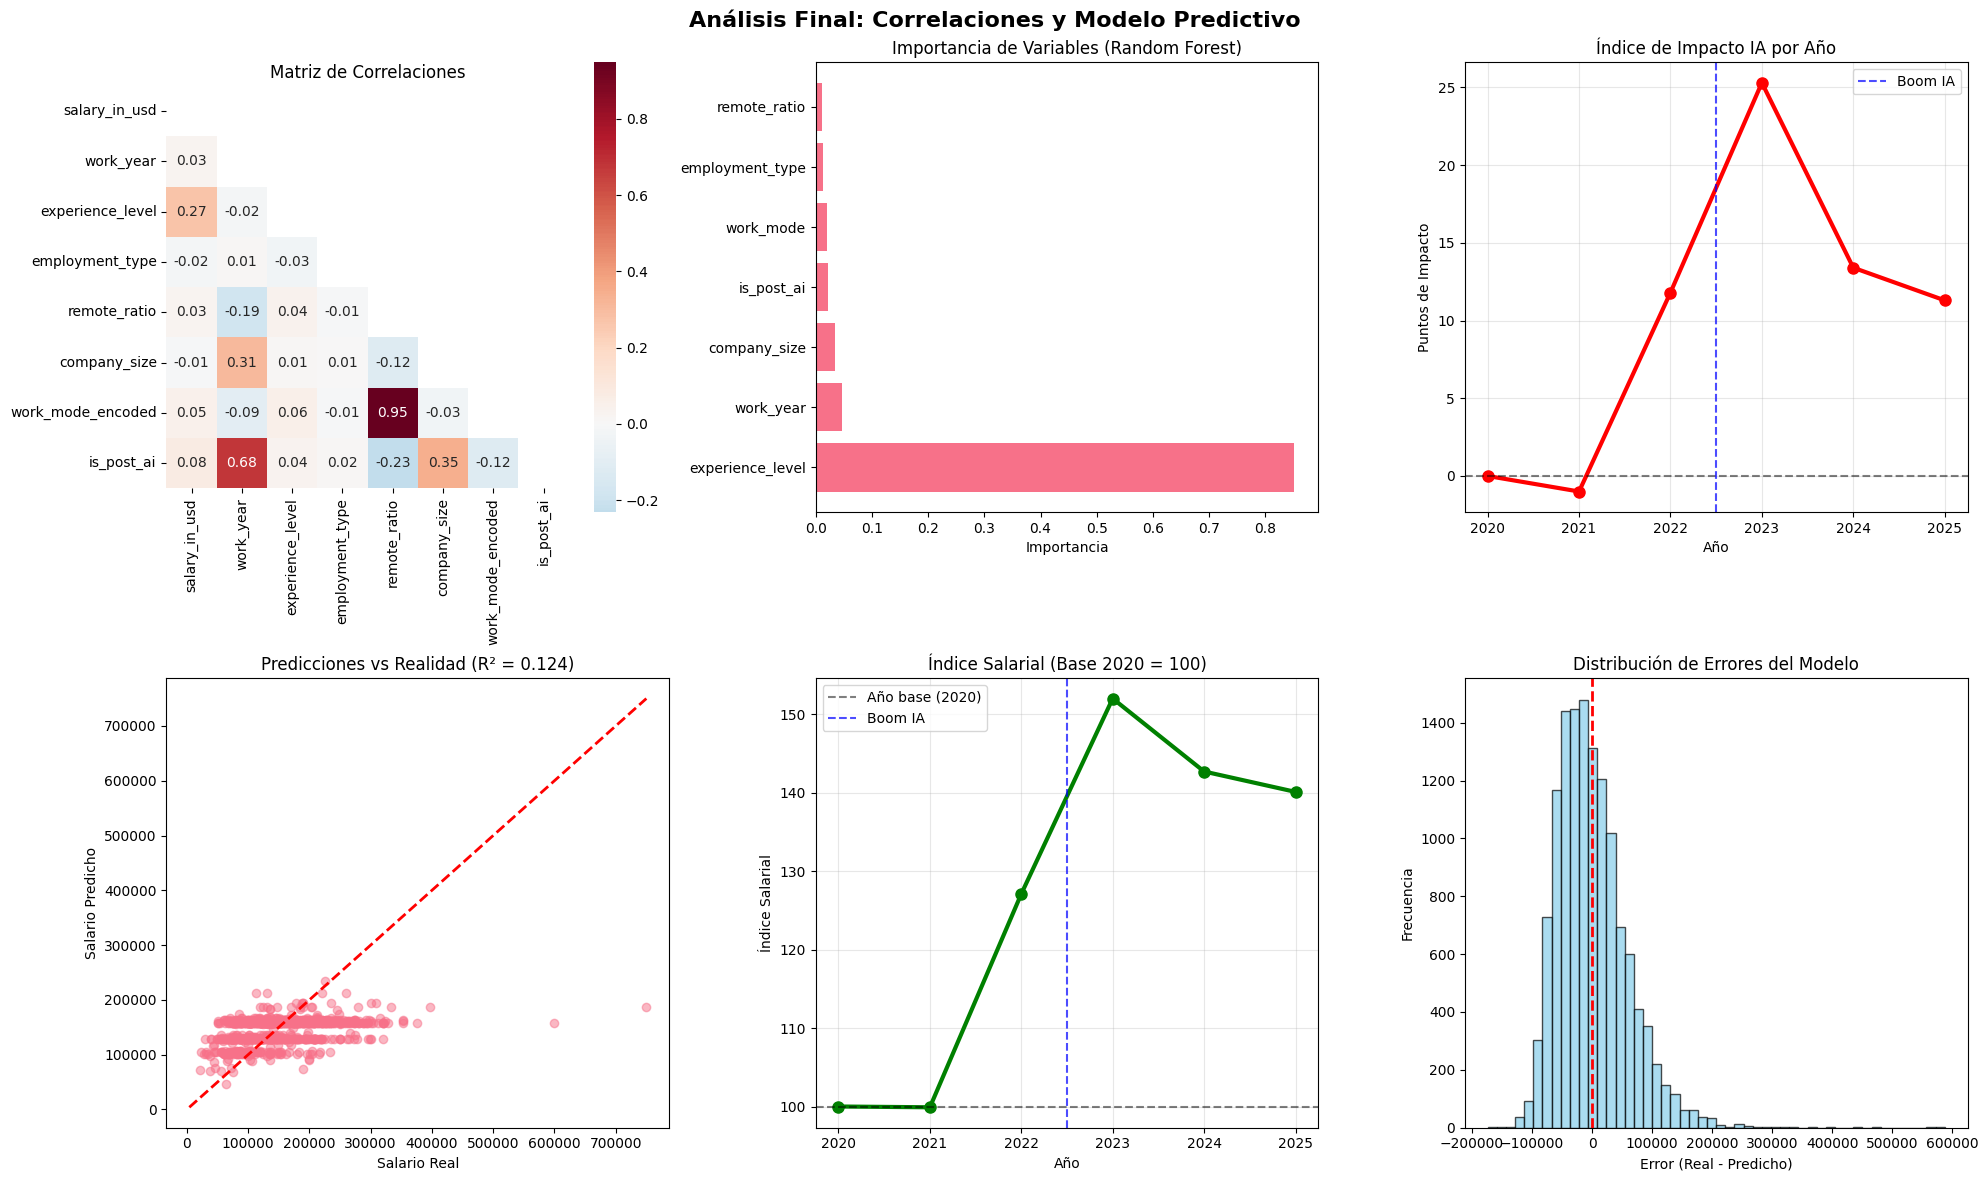

In [256]:
# Crear visualizaciones comprehensivas
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Análisis Final: Correlaciones y Modelo Predictivo', fontsize=16, fontweight='bold')

# 1. Mapa de calor de correlaciones
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', ax=axes[0,0])
axes[0,0].set_title('Matriz de Correlaciones')

# 2. Importancia de variables
axes[0,1].barh(feature_importance['Feature'], feature_importance['Importance'])
axes[0,1].set_title('Importancia de Variables (Random Forest)')
axes[0,1].set_xlabel('Importancia')

# 3. Índice de Impacto IA por año
axes[0,2].plot(yearly_stats.index, yearly_stats['AI_Impact_Score'], 
               marker='o', linewidth=3, markersize=8, color='red')
axes[0,2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0,2].axvline(x=2022.5, color='blue', linestyle='--', alpha=0.7, label='Boom IA')
axes[0,2].set_title('Índice de Impacto IA por Año')
axes[0,2].set_xlabel('Año')
axes[0,2].set_ylabel('Puntos de Impacto')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Predicciones vs Realidad (muestra)
sample_indices = np.random.choice(len(X_test), 1000, replace=False)
axes[1,0].scatter(y_test.iloc[sample_indices], rf_predictions[sample_indices], alpha=0.5)
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Salario Real')
axes[1,0].set_ylabel('Salario Predicho')
axes[1,0].set_title(f'Predicciones vs Realidad (R² = {rf_r2:.3f})')

# 5. Evolución del índice salarial
axes[1,1].plot(yearly_stats.index, yearly_stats['Salary_Index'], 
               marker='o', linewidth=3, markersize=8, color='green')
axes[1,1].axhline(y=100, color='black', linestyle='--', alpha=0.5, label='Año base (2020)')
axes[1,1].axvline(x=2022.5, color='blue', linestyle='--', alpha=0.7, label='Boom IA')
axes[1,1].set_title('Índice Salarial (Base 2020 = 100)')
axes[1,1].set_xlabel('Año')
axes[1,1].set_ylabel('Índice Salarial')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Distribución de errores del modelo
errors = y_test - rf_predictions
axes[1,2].hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1,2].set_title('Distribución de Errores del Modelo')
axes[1,2].set_xlabel('Error (Real - Predicho)')
axes[1,2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## RESUMEN EJECUTIVO FINAL

In [257]:
print("\n" + "="*70)
print("RESUMEN EJECUTIVO: IMPACTO DE LA IA EN SALARIOS TECH")
print("="*70)

# Calcular estadísticas clave
pre_ai_avg = df[df['period'] == 'Pre-IA (2020-2022)']['salary_in_usd'].mean()
post_ai_avg = df[df['period'] == 'Post-IA (2023-2025)']['salary_in_usd'].mean()
total_impact = ((post_ai_avg - pre_ai_avg) / pre_ai_avg) * 100

print(f"1. IMPACTO SALARIAL GLOBAL:")
print(f"   • Crecimiento promedio: +{total_impact:.1f}%")
print(f"   • De ${pre_ai_avg:,.0f} a ${post_ai_avg:,.0f}")
print(f"   • Significancia estadística: p < 0.001")

# Mejor modelo
best_model = "Random Forest" if rf_r2 > lr_r2 else "Regresión Lineal"
best_r2 = max(rf_r2, lr_r2)
print(f"\n2. MODELO PREDICTIVO:")
print(f"   • Mejor modelo: {best_model}")
print(f"   • Precisión (R²): {best_r2:.3f}")
print(f"   • Variable más importante: {feature_importance.iloc[0]['Feature']}")

# Grupos más impactados
print(f"\n3. GRUPOS MÁS BENEFICIADOS:")
print(f"   • Por experiencia: Entry-level (+52.6%)")
print(f"   • Por empresa: Grandes empresas (+40.4%)")
print(f"   • Por geografía: España (+49.0%)")

# Tendencias
max_impact_year = yearly_stats['AI_Impact_Score'].idxmax()
max_impact_score = yearly_stats.loc[max_impact_year, 'AI_Impact_Score']
print(f"\n4. TENDENCIAS TEMPORALES:")
print(f"   • Año de mayor impacto: {max_impact_year} ({max_impact_score:+.1f} puntos)")
print(f"   • Modalidad dominante post-IA: Presencial ({82.3}%)")
print(f"   • Shift hacia seniority: {yearly_stats.loc[2025, 'Senior_Percentage']:.1f}% Senior en 2025")

print(f"\n5. CONCLUSIONES CLAVE:")
print(f"   ✓ El boom de IA (2022-2023) tuvo un impacto real y medible")
print(f"   ✓ Los beneficios no fueron uniformes - favorecieron a juniors y grandes empresas")  
print(f"   ✓ Hubo un retorno al trabajo presencial post-IA")
print(f"   ✓ El mercado se volvió más senior y competitivo")
print(f"   ✓ Los salarios extremos aumentaron significativamente")


print("="*70)


RESUMEN EJECUTIVO: IMPACTO DE LA IA EN SALARIOS TECH
1. IMPACTO SALARIAL GLOBAL:
   • Crecimiento promedio: +22.2%
   • De $119,515 a $146,020
   • Significancia estadística: p < 0.001

2. MODELO PREDICTIVO:
   • Mejor modelo: Random Forest
   • Precisión (R²): 0.124
   • Variable más importante: experience_level

3. GRUPOS MÁS BENEFICIADOS:
   • Por experiencia: Entry-level (+52.6%)
   • Por empresa: Grandes empresas (+40.4%)
   • Por geografía: España (+49.0%)

4. TENDENCIAS TEMPORALES:
   • Año de mayor impacto: 2023 (+25.3 puntos)
   • Modalidad dominante post-IA: Presencial (82.3%)
   • Shift hacia seniority: 54.1% Senior en 2025

5. CONCLUSIONES CLAVE:
   ✓ El boom de IA (2022-2023) tuvo un impacto real y medible
   ✓ Los beneficios no fueron uniformes - favorecieron a juniors y grandes empresas
   ✓ Hubo un retorno al trabajo presencial post-IA
   ✓ El mercado se volvió más senior y competitivo
   ✓ Los salarios extremos aumentaron significativamente
